In [1]:
import pandas as pd
import os

In [2]:
# --- Configuration ---
# Define the directory where you downloaded the datasets
data_dir = 'dataset/'

In [3]:
# File paths for the datasets
fake_real_fake_path = os.path.join(data_dir, 'Fake.csv')
fake_real_true_path = os.path.join(data_dir, 'True.csv')
welfake_path = os.path.join(data_dir, 'WELFake_Dataset.csv')

In [4]:
# --- Load Datasets ---
print("Loading datasets...")
df_fake_real_fake = pd.read_csv(fake_real_fake_path)
df_fake_real_true = pd.read_csv(fake_real_true_path)

# Assign labels (0 for fake, 1 for true)
df_fake_real_fake['label'] = 0 
df_fake_real_true['label'] = 1 

df_fake_real = pd.concat([df_fake_real_fake, df_fake_real_true], ignore_index=True)
print(f"Loaded Fake and Real News Dataset: {df_fake_real.shape[0]} samples")

# Load WELFake Dataset
# This dataset is typically a single file with labels already present.
df_welfake = pd.read_csv(welfake_path)
print(f"Loaded WELFake Dataset: {df_welfake.shape[0]} samples")

Loading datasets...
Loaded Fake and Real News Dataset: 44898 samples
Loaded WELFake Dataset: 72134 samples


In [5]:
# --- Inspect and Standardize Columns and Labels ---
print("\nInspecting and standardizing columns and labels...")

# --- Inspect Column Names ---
print("\nColumns in Fake and Real News Dataset:", df_fake_real.columns)
print("Columns in WELFake Dataset:", df_welfake.columns)

print("\nLabels in Fake and Real News Dataset (should be 0 or 1):\n", df_fake_real['label'].value_counts())
print("Labels in WELFake Dataset (should be 0 or 1):\n", df_welfake['label'].value_counts())


Inspecting and standardizing columns and labels...

Columns in Fake and Real News Dataset: Index(['title', 'text', 'subject', 'date', 'label'], dtype='object')
Columns in WELFake Dataset: Index(['Serial number', 'title', 'text', 'label'], dtype='object')

Labels in Fake and Real News Dataset (should be 0 or 1):
 label
0    23481
1    21417
Name: count, dtype: int64
Labels in WELFake Dataset (should be 0 or 1):
 label
1    37106
0    35028
Name: count, dtype: int64


In [6]:
# --- Combine Datasets ---
print("\nCombining datasets...")

# Select only the standardized columns needed before concatenating
cols_to_use = ['title', 'text', 'label']
df_fake_real_subset = df_fake_real[cols_to_use]
# Drop potential 'Serial' column or other unnecessary columns from WELFake
df_welfake_subset = df_welfake[cols_to_use]

# Concatenate the two dataframes
df_combined = pd.concat([df_fake_real_subset, df_welfake_subset], ignore_index=True)
print(f"Combined dataset initial size: {df_combined.shape[0]} samples")


Combining datasets...
Combined dataset initial size: 117032 samples


In [7]:
# --- Handle Duplicates ---
print("\nHandling duplicates based on text content...")

# Drop duplicates based on the 'text' column
# Keep the first occurrence found
initial_samples = df_combined.shape[0]
df_combined.drop_duplicates(subset=['text'], keep='first', inplace=True)
samples_after_deduplication = df_combined.shape[0]

print(f"Samples removed due to duplication: {initial_samples - samples_after_deduplication}")
print(f"Combined dataset size after de-duplication: {samples_after_deduplication} samples")



Handling duplicates based on text content...
Samples removed due to duplication: 34800
Combined dataset size after de-duplication: 82232 samples


In [8]:
# --- Check for Missing Values ---
print("\nChecking for missing values...")
print(df_combined.isnull().sum())

# If there are missing values in 'title' or 'text', decide how to handle them.
# Dropping rows with missing text is often a reasonable approach for text classification.
initial_samples_after_dedup = df_combined.shape[0]
df_combined.dropna(subset=['text'], inplace=True)
samples_after_dropna = df_combined.shape[0]

if initial_samples_after_dedup - samples_after_dropna > 0:
    print(f"Samples removed due to missing text: {initial_samples_after_dedup - samples_after_dropna}")
    print(f"Combined dataset size after dropping NaNs: {samples_after_dropna} samples")
else:
     print("No samples removed due to missing text.")


Checking for missing values...
title    518
text       1
label      0
dtype: int64
Samples removed due to missing text: 1
Combined dataset size after dropping NaNs: 82231 samples


In [9]:
# --- Final Dataset Summary ---
print("\n--- Final Combined Dataset Summary ---")
print(f"Total samples: {df_combined.shape[0]}")
print("\nLabel distribution:")
print(df_combined['label'].value_counts())
print("\nSample data:")
print(df_combined.head())

# Reset index after dropping rows
df_combined.reset_index(drop=True, inplace=True)


--- Final Combined Dataset Summary ---
Total samples: 82231

Label distribution:
label
0    47633
1    34598
Name: count, dtype: int64

Sample data:
                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text  label  
0  Donald Trump just couldn t wish all Americans ...      0  
1  House Intelligence Committee Chairman Devin Nu...      0  
2  On Friday, it was revealed that former Milwauk...      0  
3  On Christmas day, Donald Trump announced that ...      0  
4  Pope Francis used his annual Christmas Day mes...      0  


In [30]:
import spacy
import re

In [37]:
nlp = spacy.load("en_core_web_sm")
custom_stop_words = set()

In [38]:
# --- Build the Preprocessing Functions ---
# Function for core text cleaning (tokenization, lemma, stop words, etc.)
def preprocess_text(text):
    if not isinstance(text, str):
        # Handle potential non-string entries (e.g., NaNs converted to float)
        # Return empty string or handle as missing in previous step
        return ""

    # 1. Lowercasing and remove leading/trailing whitespace
    text = text.lower().strip()

    # 2. Remove URLs (common in online text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # 3. Remove mentions (@users) and hashtags (#topics) if data was from social media (less likely for news articles)
    # text = re.sub(r'@\w+|#\w+', '', text) # Uncomment if applicable

    # 4. Remove punctuation - keep only letters and spaces
    # Using regex for simplicity. spaCy's tokenizer handles some punctuation smartly,
    # but this ensures we only keep alphanumeric and spaces.
    text = re.sub(r'[^a-z\s]', '', text)

    # 5. Process with spaCy for tokenization, stop words, and lemmatization
    doc = nlp(text) # Process the text with spaCy

    # Iterate through tokens
    cleaned_tokens = []
    for token in doc:
        # Check if token is not punctuation, not whitespace, not a stop word, and is alphabetic
        # spaCy's is_punct, is_space, is_stop flags are efficient
        if not token.is_punct and not token.is_space and not token.is_stop and token.is_alpha:
             # 6. Lemmatization
             cleaned_tokens.append(token.lemma_)
            
    return cleaned_tokens # Returning list of tokens is often better for flexibility
    
# Function to count sentences using spaCy
def count_sentences(text):
    if not isinstance(text, str) or not text.strip():
        return 0
    if nlp_sent is None: # Check if sentence nlp model failed to load
        return 0
    doc = nlp_sent(text)
    return len(list(doc.sents)) # Convert to list to count sentences

# Function to get average sentence length (in tokens from processed_text)
def avg_sentence_length_processed(processed_tokens, sentence_count):
    if sentence_count is None or sentence_count == 0 or not processed_tokens:
        return 0.0
    total_tokens = len(processed_tokens)
    return total_tokens / sentence_count

# Function to count proportion of uppercase characters (ignoring non-alpha)
def uppercase_char_proportion(text):
    if not isinstance(text, str) or not text.strip():
         return 0.0
    # Count uppercase alpha chars / total alpha chars in original text
    alpha_chars = re.findall(r'[a-zA-Z]', text)
    if not alpha_chars: return 0.0
    upper_count = sum(1 for char in alpha_chars if char.isupper())
    return upper_count / len(alpha_chars)

# Function to count specific punctuation
def count_punctuation(text, punct_char='!'):
    if not isinstance(text, str):
        return 0
    return text.count(punct_char)

In [41]:
# --- Apply Preprocessing to DataFrame ---
from tqdm.auto import tqdm
from pandarallel import pandarallel # Import pandarallel

num_cores = os.cpu_count()
workers_to_use = max(1, num_cores - 2) # Use at least 1 worker, or cores - 1
pandarallel.initialize(progress_bar=True, nb_workers=workers_to_use)
print(f"Initializing pandarallel with {workers_to_use} workers...")

print("\nApplying core text preprocessing (tokenization, lemma) (with parallel progress)...")

df_combined['processed_text'] = df_combined['text'].parallel_apply(preprocess_text)
df_combined['processed_title'] = df_combined['title'].parallel_apply(preprocess_text)

print("\nCalculating structural and stylistic features (with parallel progress)...")

df_combined['sentence_count'] = df_combined['text'].parallel_apply(count_sentences)
# Avg sentence length calculation is fast once sentence_count and processed_text are ready
    
print("Calculating average sentence length (single-threaded)...")
df_combined['avg_sentence_length'] = df_combined.apply(
             lambda row: avg_sentence_length_processed(row.get('processed_text', []), row.get('sentence_count', 0)),
             axis=1
        )

# Basic Stylistic Features (Parallelized)
# Parallelize these as they use apply on raw text

df_combined['uppercase_char_prop'] = df_combined['text'].parallel_apply(uppercase_char_proportion)
df_combined['exclamation_count'] = df_combined['text'].parallel_apply(lambda x: count_punctuation(x, '!'))
df_combined['question_count'] = df_combined['text'].parallel_apply(lambda x: count_punctuation(x, '?'))
df_combined['quotes_count'] = df_combined['text'].parallel_apply(lambda x: count_punctuation(x, '"') + count_punctuation(x, "'"))

# --- Display Sample and Save Processed Data ---
print("\nPreprocessing and all feature calculations complete.")
print("\nSample original and processed data with new features:")
print(df_combined.head())

# --- Configuration ---
# Define the directory to save your processed data
data_dir = 'dataset/'
processed_data_path = os.path.join(data_dir, 'combined_processed_articles.pkl')

# --- Saving ---
# Assuming df_combined is the DataFrame after running the preprocessing code

print(f"\nSaving processed data to {processed_data_path}...")
df_combined.to_pickle(processed_data_path)
print("Processed data saved successfully.")

INFO: Pandarallel will run on 9 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Initializing pandarallel with 9 workers...

Applying core text preprocessing (tokenization, lemma) (with parallel progress)...



Calculating structural and stylistic features (with parallel progress)...


Calculating average sentence length (single-threaded)...



Preprocessing and all feature calculations complete.

Sample original and processed data with new features:
                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text  label  \
0  Donald Trump just couldn t wish all Americans ...      0   
1  House Intelligence Committee Chairman Devin Nu...      0   
2  On Friday, it was revealed that former Milwauk...      0   
3  On Christmas day, Donald Trump announced that ...      0   
4  Pope Francis used his annual Christmas Day mes...      0   

                                      processed_text  \
0  [donald, trump, couldn, t, wish, americans, ha...   
1  [house, intelligence, committee, chairman, dev...   
2  [fri

In [65]:
# --- Loading processed dataset ---
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import nltk
from nltk import ngrams

# --- Configuration ---
# Define the directory where you saved your processed data
data_dir = 'dataset/'
processed_data_path = os.path.join(data_dir, 'combined_processed_articles.pkl')

# --- Loading ---
print(f"Loading processed data from {processed_data_path}...")
df_combined = pd.read_pickle(processed_data_path)
print("Processed data loaded successfully.")
print(f"Loaded DataFrame shape: {df_combined.shape}")
print("Columns:", df_combined.columns)

Loading processed data from dataset/combined_processed_articles.pkl...
Processed data loaded successfully.
Loaded DataFrame shape: (82231, 12)
Columns: Index(['title', 'text', 'label', 'processed_text', 'processed_title',
       'processed_text_length', 'sentence_count', 'avg_sentence_length',
       'uppercase_char_prop', 'exclamation_count', 'question_count',
       'quotes_count'],
      dtype='object')



Starting EDA on processed data and derived features...

Analyzing token and N-gram frequencies...

50 Most Common Tokens Overall:
[('say', 352094), ('s', 247919), ('trump', 237552), ('president', 104279), ('people', 97043), ('state', 95470), ('year', 88579), ('new', 80361), ('clinton', 73580), ('mr', 71617), ('government', 65066), ('time', 62610), ('tell', 61283), ('not', 60217), ('house', 57505), ('like', 57309), ('republican', 55218), ('go', 54328), ('country', 54068), ('campaign', 53012), ('election', 52883), ('united', 51986), ('come', 50279), ('know', 49969), ('party', 48720), ('donald', 48103), ('work', 47545), ('official', 47357), ('include', 47071), ('obama', 45688), ('vote', 44966), ('white', 44591), ('t', 44216), ('want', 44149), ('report', 43715), ('right', 43605), ('day', 43504), ('take', 43451), ('states', 43163), ('group', 42664), ('think', 41238), ('call', 40420), ('news', 40093), ('law', 39277), ('support', 39134), ('reuters', 39094), ('week', 38750), ('percent', 36498

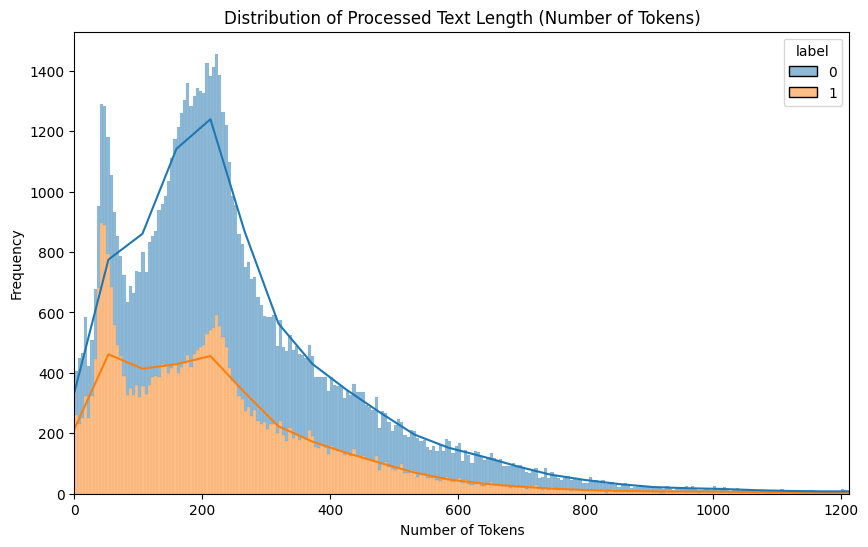


Generating Word Clouds...


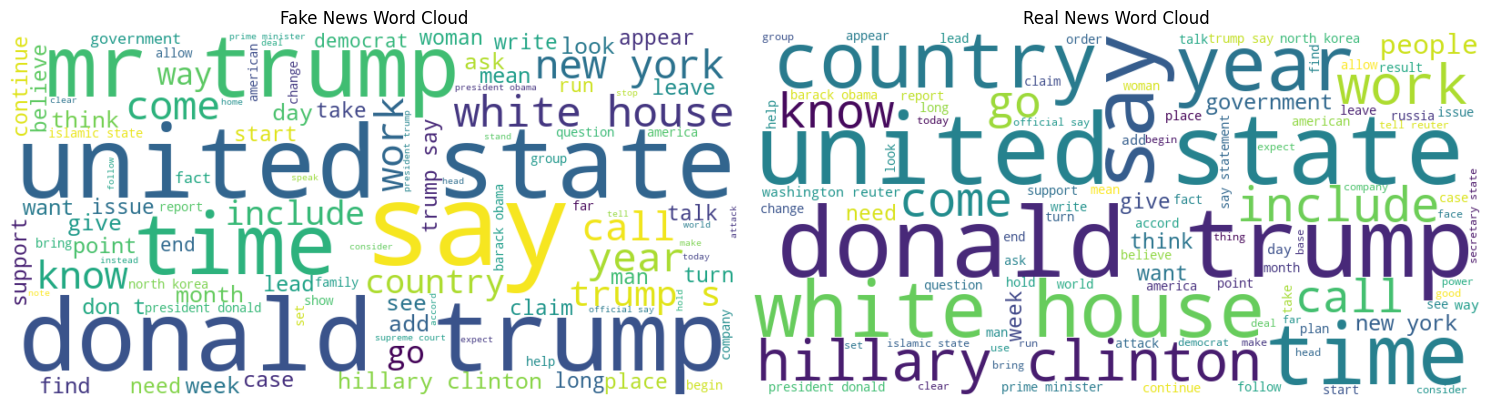


Generating Side-by-Side Token/Bigram Plots...


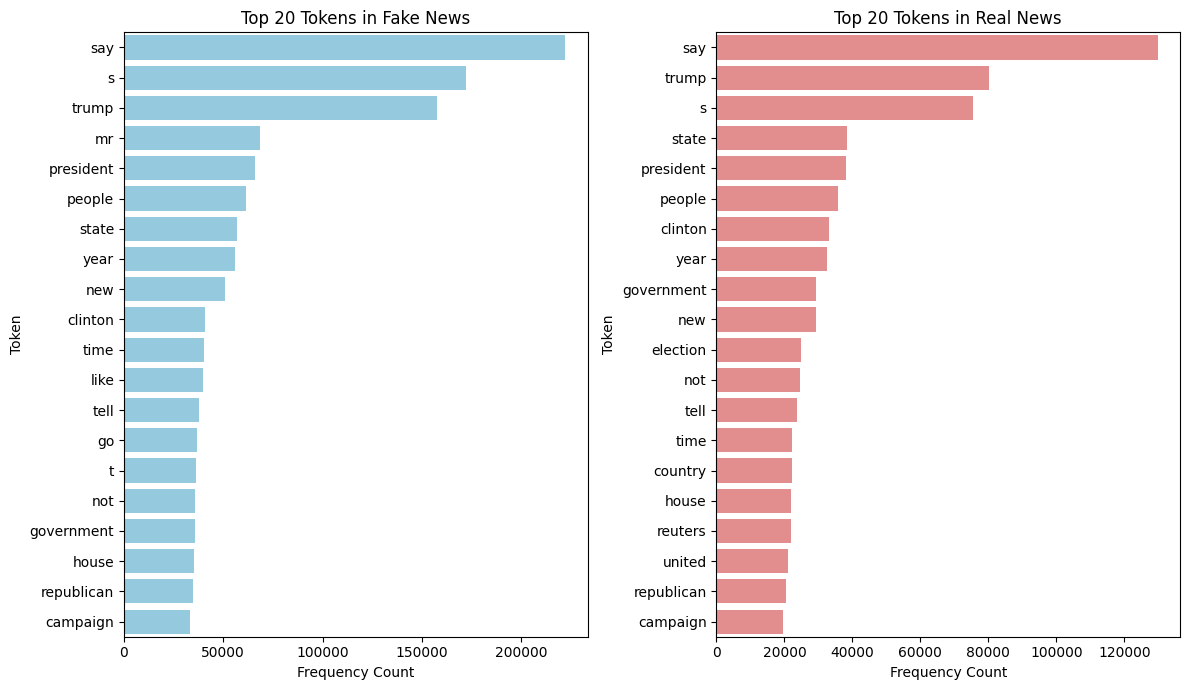

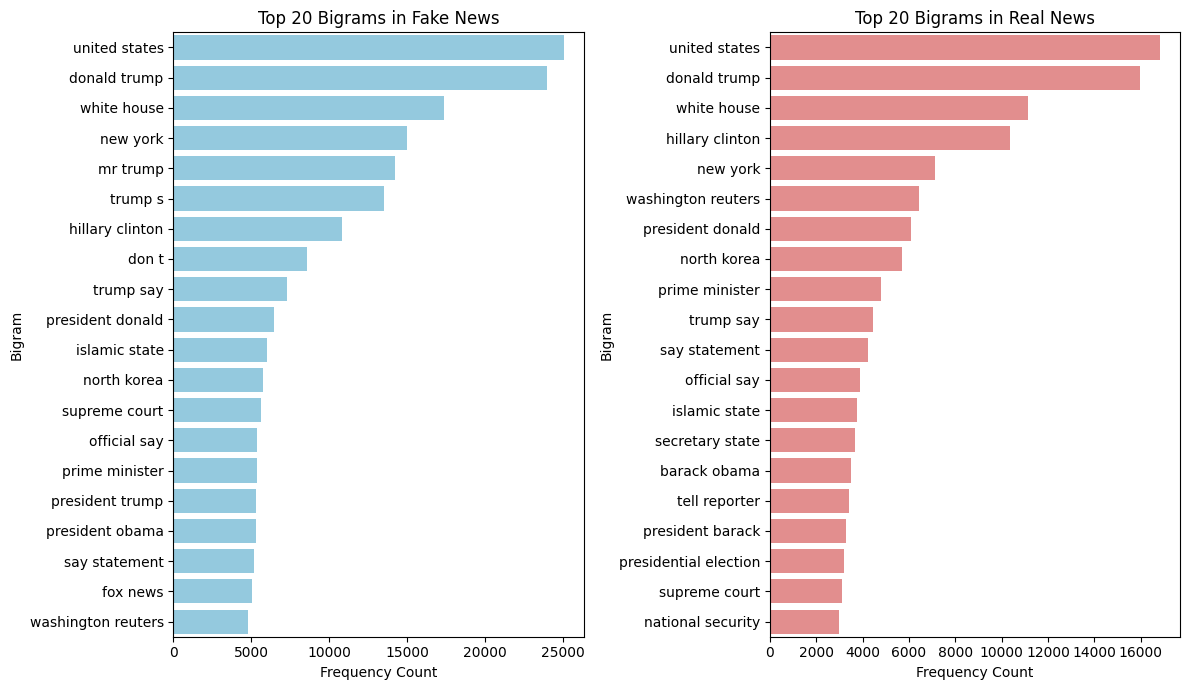


Analyzing Structural Features (Sentence Count and Length)...

Sentence Count Summary:
         count       mean        std  min   25%   50%   75%     max
label                                                              
0      47633.0  25.949552  26.647534  0.0  13.0  20.0  31.0  1351.0
1      34598.0  21.262241  33.229407  0.0   8.0  15.0  26.0  1553.0


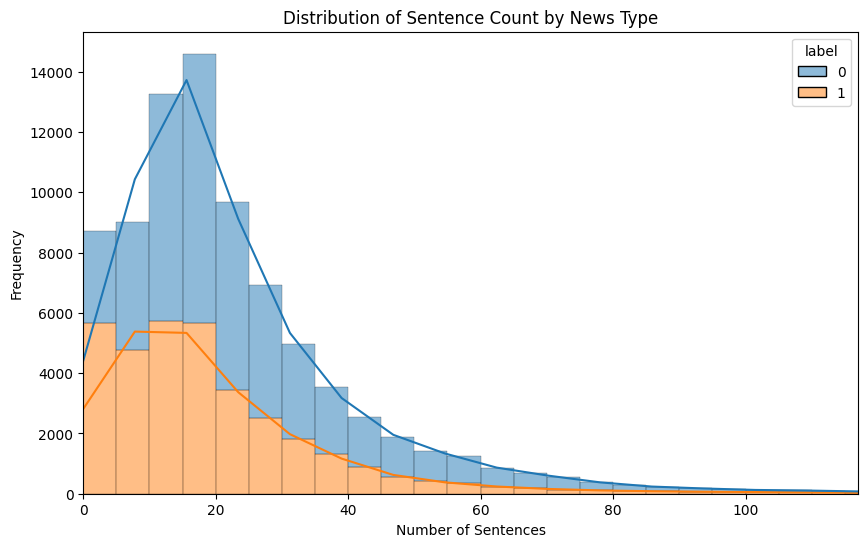


Average Sentence Length Summary:
         count       mean       std  min        25%        50%        75%  \
label                                                                       
0      47633.0  12.005989  3.400298  0.0   9.833333  11.900000  13.952381   
1      34598.0  12.865415  4.228035  0.0  10.538462  12.757359  14.875000   

        max  
label        
0      93.6  
1      93.6  


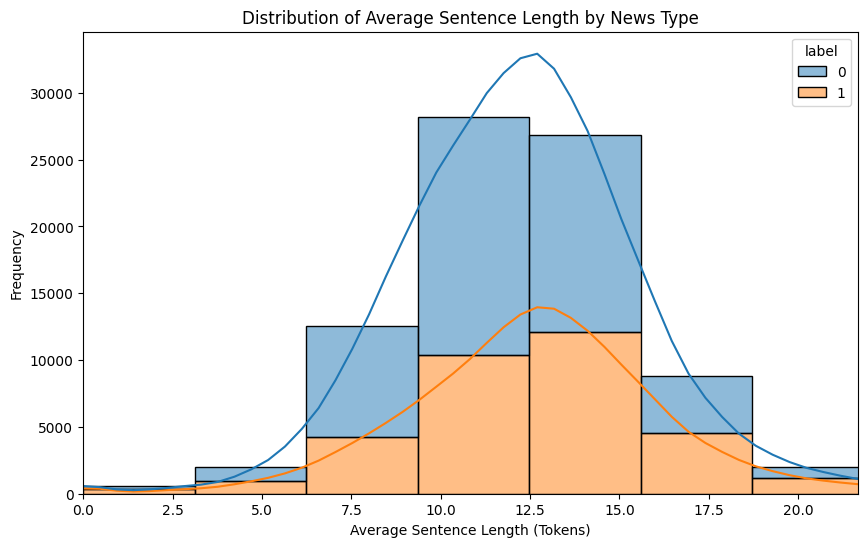


Analyzing Basic Stylistic Features (Caps, Punctuation)...

Uppercase Character Proportion Summary:
         count      mean       std  min       25%       50%       75%  max
label                                                                     
0      47633.0  0.049403  0.037588  0.0  0.035743  0.043303  0.053490  1.0
1      34598.0  0.055018  0.043513  0.0  0.038185  0.047121  0.060343  1.0

Exclamation Mark Count Summary:
         count      mean       std  min  25%  50%  75%    max
label                                                        
0      47633.0  0.383432  1.408315  0.0  0.0  0.0  0.0  133.0
1      34598.0  0.367276  2.418866  0.0  0.0  0.0  0.0  213.0

Question Mark Count Summary:
         count      mean       std  min  25%  50%  75%    max
label                                                        
0      47633.0  0.832763  2.152337  0.0  0.0  0.0  1.0  112.0
1      34598.0  0.697410  3.100886  0.0  0.0  0.0  0.0  159.0

Quotes Count Summary:
         count    

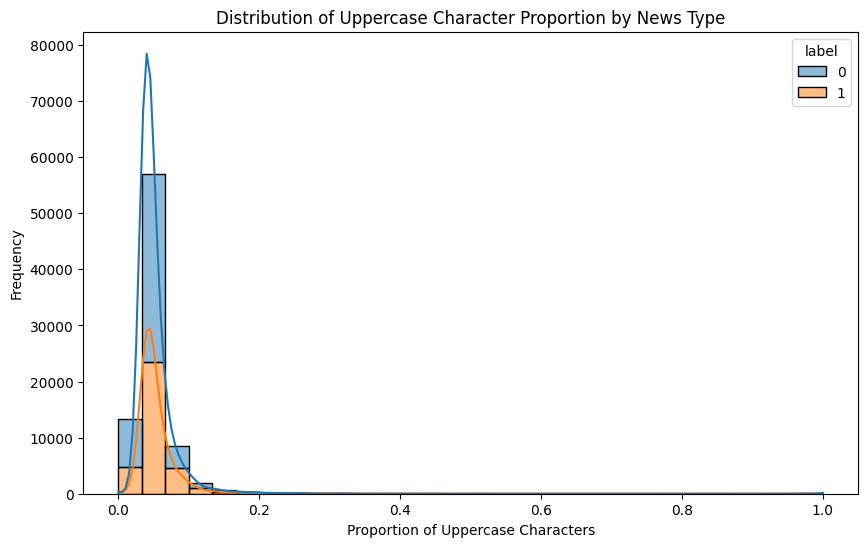

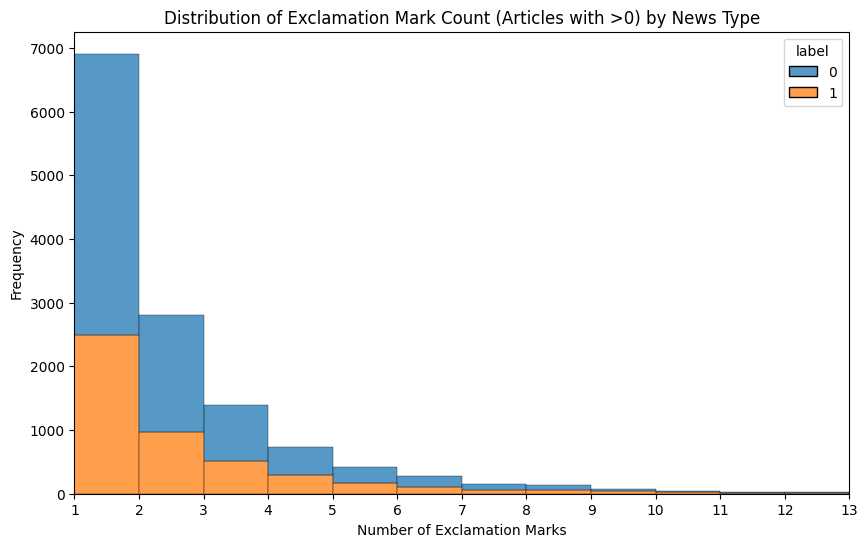

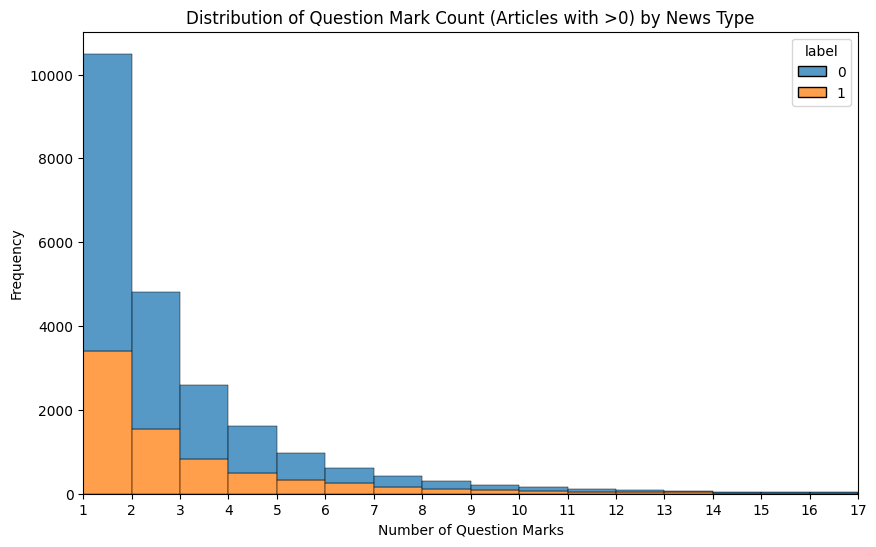

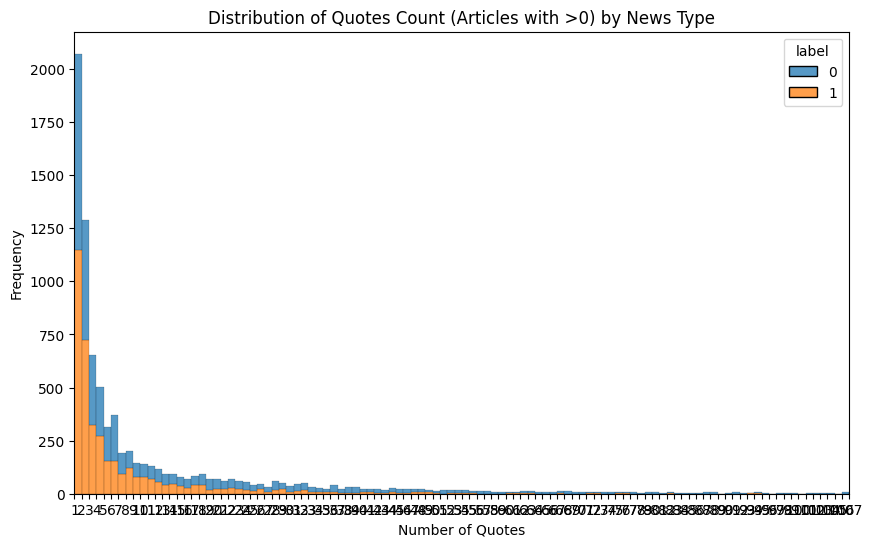


Skipping Analysis by Subject Category: 'subject' column not found or is empty.

Skipping Temporal Analysis: 'date' column not found or is empty.

EDA complete. Analyze the outputs and plots for insights!


In [66]:
# --- EDA on Processed Text and Derived Features ---
print("\nStarting EDA on processed data and derived features...")

# Check for necessary columns after loading
required_cols = ['label', 'processed_text', 'processed_title',
                 'sentence_count', 'avg_sentence_length',
                 'uppercase_char_prop', 'exclamation_count',
                 'question_count', 'quotes_count'] # Include subject and date if available
for col in required_cols:
    if col not in df_combined.columns:
        print(f"Warning: Required column '{col}' not found in loaded DataFrame. Some EDA steps may be skipped or fail.")


# --- Token and N-gram Frequency Analysis ---
# This part uses the 'processed_text' column

print("\nAnalyzing token and N-gram frequencies...")
# Combine all processed tokens into a single list
# Use .dropna() on processed_text just in case any None/NaN values slipped through
all_tokens = [token for sublist in df_combined['processed_text'].dropna() for token in sublist if token] # Added check for None/NaN sublists

# Calculate token frequencies
if all_tokens:
    token_counts = Counter(all_tokens)
    print("\n50 Most Common Tokens Overall:")
    print(token_counts.most_common(50))

    # Separate tokens by label (assuming label 0 is fake, 1 is real)
    fake_tokens = [token for sublist in df_combined[df_combined['label'] == 0]['processed_text'].dropna() for token in sublist if token]
    real_tokens = [token for sublist in df_combined[df_combined['label'] == 1]['processed_text'].dropna() for token in sublist if token]

    fake_token_counts = Counter(fake_tokens)
    real_token_counts = Counter(real_tokens)

    print("\n50 Most Common Tokens in Fake News:")
    print(fake_token_counts.most_common(50))

    print("\n50 Most Common Tokens in Real News:")
    print(real_token_counts.most_common(50))

    # --- Analyze N-grams (Example: Bigrams) ---
    # Function to get ngrams (requires list of tokens)
    def get_ngrams(token_list, n):
        if not token_list or len(token_list) < n:
            return []
        return list(ngrams(token_list, n))

    # Get bigrams (sequence of 2 tokens)
    print("\nCalculating Bigram frequencies...")
    fake_bigrams = [bigram for token_list in df_combined[df_combined['label'] == 0]['processed_text'].dropna() for bigram in get_ngrams(token_list, 2)]
    real_bigrams = [bigram for token_list in df_combined[df_combined['label'] == 1]['processed_text'].dropna() for bigram in get_ngrams(token_list, 2)]

    print("\n50 Most Common Bigrams in Fake News:")
    print(Counter(fake_bigrams).most_common(50))

    print("\n50 Most Common Bigrams in Real News:")
    print(Counter(real_bigrams).most_common(50))

else:
    print("\nNo processed tokens found for frequency analysis.")


# --- Analyze Processed Text Length ---
# This uses 'processed_text_length' which should have been created in preprocessing
if 'processed_text_length' in df_combined.columns:
    print("\nAnalyzing Processed Text Length...")
    print(df_combined.groupby('label')['processed_text_length'].describe())

    plt.figure(figsize=(10, 6))
    sns.histplot(data=df_combined, x='processed_text_length', hue='label', kde=True, multiple="stack", bins=range(0, int(df_combined['processed_text_length'].max()) + 2, 5))
    plt.title('Distribution of Processed Text Length (Number of Tokens)')
    plt.xlabel('Number of Tokens')
    plt.ylabel('Frequency')
    upper_limit_len = df_combined['processed_text_length'].quantile(0.99)
    plt.xlim(0, upper_limit_len + 1)
    plt.show()
else:
    print("\nSkipping processed text length analysis: 'processed_text_length' column not found.")


# --- Word Clouds (Visual EDA) ---
# This uses 'processed_text'

print("\nGenerating Word Clouds...")
# Join processed tokens back into strings for wordcloud
# Ensure handling of potential empty lists/NaN
fake_text_combined_str = " ".join([token for sublist in df_combined[df_combined['label'] == 0]['processed_text'].dropna() for token in sublist if token])
real_text_combined_str = " ".join([token for sublist in df_combined[df_combined['label'] == 1]['processed_text'].dropna() for token in sublist if token])

if fake_text_combined_str and real_text_combined_str:
    plt.figure(figsize=(15, 8))

    plt.subplot(1, 2, 1)
    wordcloud_fake = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(fake_text_combined_str)
    plt.imshow(wordcloud_fake, interpolation='bilinear')
    plt.axis('off')
    plt.title('Fake News Word Cloud')

    plt.subplot(1, 2, 2)
    wordcloud_real = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(real_text_combined_str)
    plt.imshow(wordcloud_real, interpolation='bilinear')
    plt.axis('off')
    plt.title('Real News Word Cloud')

    plt.tight_layout()
    plt.show()
else:
    print("\nSkipping Word Clouds: No text available after processing.")


# --- Side-by-Side Comparison of Top Terms/N-grams (Visual) ---
# This uses the counts calculated earlier

if 'fake_token_counts' in locals() and 'real_token_counts' in locals() and fake_token_counts and real_token_counts:
    print("\nGenerating Side-by-Side Token/Bigram Plots...")
    n_top_terms = 20 # How many top terms to compare

    top_fake_terms = pd.DataFrame(fake_token_counts.most_common(n_top_terms), columns=['token', 'count'])
    top_real_terms = pd.DataFrame(real_token_counts.most_common(n_top_terms), columns=['token', 'count'])

    plt.figure(figsize=(12, 7))

    plt.subplot(1, 2, 1)
    sns.barplot(x='count', y='token', data=top_fake_terms, color='skyblue')
    plt.title(f'Top {n_top_terms} Tokens in Fake News')
    plt.xlabel('Frequency Count')
    plt.ylabel('Token')

    plt.subplot(1, 2, 2)
    sns.barplot(x='count', y='token', data=top_real_terms, color='lightcoral')
    plt.title(f'Top {n_top_terms} Tokens in Real News')
    plt.xlabel('Frequency Count')
    plt.ylabel('Token')

    plt.tight_layout()
    plt.show()

    # Side-by-side for Bigrams
    if 'fake_bigrams' in locals() and 'real_bigrams' in locals(): # Check if bigrams were calculated
        n_top_bigrams = 20
        top_fake_bigrams = pd.DataFrame(Counter(fake_bigrams).most_common(n_top_bigrams), columns=['bigram', 'count'])
        top_real_bigrams = pd.DataFrame(Counter(real_bigrams).most_common(n_top_bigrams), columns=['bigram', 'count'])

        if not top_fake_bigrams.empty and not top_real_bigrams.empty:
            # Convert tuple bigram to string for plotting
            top_fake_bigrams['bigram_str'] = top_fake_bigrams['bigram'].apply(lambda x: ' '.join(x))
            top_real_bigrams['bigram_str'] = top_real_bigrams['bigram'].apply(lambda x: ' '.join(x))


            plt.figure(figsize=(12, 7))

            plt.subplot(1, 2, 1)
            sns.barplot(x='count', y='bigram_str', data=top_fake_bigrams, color='skyblue')
            plt.title(f'Top {n_top_bigrams} Bigrams in Fake News')
            plt.xlabel('Frequency Count')
            plt.ylabel('Bigram')

            plt.subplot(1, 2, 2)
            sns.barplot(x='count', y='bigram_str', data=top_real_bigrams, color='lightcoral')
            plt.title(f'Top {n_top_bigrams} Bigrams in Real News')
            plt.xlabel('Frequency Count')
            plt.ylabel('Bigram')

            plt.tight_layout()
            plt.show()
        else:
            print("\nSkipping side-by-side Bigram plots: No Bigram counts available.")
    else:
         print("\nSkipping side-by-side Bigram plots: Bigram lists not found.")


else:
     print("\nSkipping side-by-side Token/Bigram plots: Token counts not available.")


# --- EDA on Structural Features ---
# Uses 'sentence_count' and 'avg_sentence_length' columns
if 'sentence_count' in df_combined.columns and 'avg_sentence_length' in df_combined.columns:
    print("\nAnalyzing Structural Features (Sentence Count and Length)...")

    # Describe and visualize sentence count
    print("\nSentence Count Summary:")
    print(df_combined.groupby('label')['sentence_count'].describe())

    plt.figure(figsize=(10, 6))
    sns.histplot(data=df_combined, x='sentence_count', hue='label', kde=True, multiple="stack", bins=range(0, int(df_combined['sentence_count'].max()) + 2, 5)) # Bin by 5
    plt.title('Distribution of Sentence Count by News Type')
    plt.xlabel('Number of Sentences')
    plt.ylabel('Frequency')
    upper_limit = df_combined['sentence_count'].quantile(0.99) # Use 99th percentile
    plt.xlim(0, upper_limit + 1)
    plt.show()

    # Describe and visualize average sentence length
    print("\nAverage Sentence Length Summary:")
    print(df_combined.groupby('label')['avg_sentence_length'].describe())

    plt.figure(figsize=(10, 6))
    sns.histplot(data=df_combined, x='avg_sentence_length', hue='label', kde=True, multiple="stack", bins=30)
    plt.title('Distribution of Average Sentence Length by News Type')
    plt.xlabel('Average Sentence Length (Tokens)')
    plt.ylabel('Frequency')
    upper_limit_len = df_combined['avg_sentence_length'].quantile(0.98) # Use 98th percentile
    plt.xlim(0, upper_limit_len + 1)
    plt.show()

else:
    print("\nSkipping structural features analysis: Required columns not found.")


# --- EDA on Basic Stylistic Features ---
# Uses 'uppercase_char_prop', 'exclamation_count', 'question_count', 'quotes_count' columns
if all(col in df_combined.columns for col in ['uppercase_char_prop', 'exclamation_count', 'question_count', 'quotes_count']):
    print("\nAnalyzing Basic Stylistic Features (Caps, Punctuation)...")

    print("\nUppercase Character Proportion Summary:")
    print(df_combined.groupby('label')['uppercase_char_prop'].describe())

    print("\nExclamation Mark Count Summary:")
    print(df_combined.groupby('label')['exclamation_count'].describe())

    print("\nQuestion Mark Count Summary:")
    print(df_combined.groupby('label')['question_count'].describe())

    print("\nQuotes Count Summary:")
    print(df_combined.groupby('label')['quotes_count'].describe())


    # Visualize Uppercase proportion
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df_combined, x='uppercase_char_prop', hue='label', kde=True, multiple="stack", bins=30)
    plt.title('Distribution of Uppercase Character Proportion by News Type')
    plt.xlabel('Proportion of Uppercase Characters')
    plt.ylabel('Frequency')
    plt.show()

    # Visualize Exclamation Mark Count (Focus on articles with > 0)
    df_combined_exclamations = df_combined[df_combined['exclamation_count'] > 0].copy()
    if not df_combined_exclamations.empty:
        plt.figure(figsize=(10, 6))
        max_exclamations = int(df_combined_exclamations['exclamation_count'].max())
        bins = range(1, max_exclamations + 2)
        sns.histplot(data=df_combined_exclamations, x='exclamation_count', hue='label', kde=False, multiple="stack", bins=bins)
        plt.title('Distribution of Exclamation Mark Count (Articles with >0) by News Type')
        plt.xlabel('Number of Exclamation Marks')
        plt.ylabel('Frequency')
        upper_limit_excl = df_combined_exclamations['exclamation_count'].quantile(0.99)
        plt.xlim(1, upper_limit_excl + 1)
        plt.xticks(range(1, int(upper_limit_excl + 2)))
        plt.show()
    else:
        print("\nNo articles found with exclamation marks for plotting.")

    # Visualize Question Mark Count (Focus on articles with > 0)
    df_combined_questions = df_combined[df_combined['question_count'] > 0].copy()
    if not df_combined_questions.empty:
        plt.figure(figsize=(10, 6))
        max_questions = int(df_combined_questions['question_count'].max())
        bins = range(1, max_questions + 2)
        sns.histplot(data=df_combined_questions, x='question_count', hue='label', kde=False, multiple="stack", bins=bins)
        plt.title('Distribution of Question Mark Count (Articles with >0) by News Type')
        plt.xlabel('Number of Question Marks')
        plt.ylabel('Frequency')
        upper_limit_quest = df_combined_questions['question_count'].quantile(0.99)
        plt.xlim(1, upper_limit_quest + 1)
        plt.xticks(range(1, int(upper_limit_quest + 2)))
        plt.show()
    else:
        print("\nNo articles found with question marks for plotting.")

    # Visualize Quotes Count (Focus on articles with > 0)
    df_combined_quotes = df_combined[df_combined['quotes_count'] > 0].copy()
    if not df_combined_quotes.empty:
        plt.figure(figsize=(10, 6))
        max_quotes = int(df_combined_quotes['quotes_count'].max())
        bins = range(1, max_quotes + 2)
        sns.histplot(data=df_combined_quotes, x='quotes_count', hue='label', kde=False, multiple="stack", bins=bins)
        plt.title('Distribution of Quotes Count (Articles with >0) by News Type')
        plt.xlabel('Number of Quotes')
        plt.ylabel('Frequency')
        upper_limit_quotes = df_combined_quotes['quotes_count'].quantile(0.99)
        plt.xlim(1, upper_limit_quotes + 1)
        plt.xticks(range(1, int(upper_limit_quotes + 2)))
        plt.show()
    else:
        print("\nNo articles found with quotes for plotting.")

else:
    print("\nSkipping basic stylistic features analysis: Required columns not found.")


# --- EDA on Subject Category (if available) ---
if 'subject' in df_combined.columns and not df_combined['subject'].isnull().all():
    print("\nAnalyzing by Subject Category...")

    # Clean up subject names (optional, depending on your data)
    df_combined['subject_cleaned'] = df_combined['subject'].astype(str).str.lower().str.strip()
    # Handle potential 'nan' strings if original column had NaNs
    df_combined['subject_cleaned'] = df_combined['subject_cleaned'].replace('nan', None)

    # Drop rows where subject is None after cleaning
    df_combined_with_subject = df_combined.dropna(subset=['subject_cleaned']).copy() # Use copy()

    if not df_combined_with_subject.empty:
         # Count occurrences of each subject
        print("\nSubject counts (cleaned):")
        print(df_combined_with_subject['subject_cleaned'].value_counts())

        # Analyze real vs fake counts per subject
        subject_label_counts = df_combined_with_subject.groupby(['subject_cleaned', 'label']).size().unstack(fill_value=0)
        print("\nReal/Fake counts by Subject (cleaned):")
        print(subject_label_counts)

        # Calculate proportion of fake news within each subject
        subject_label_counts['total'] = subject_label_counts[0] + subject_label_counts[1]
        subject_label_counts['fake_proportion'] = subject_label_counts[0] / subject_label_counts['total'].replace(0, np.nan)

        print("\nProportion of Fake News by Subject (cleaned):")
        print(subject_label_counts['fake_proportion'].sort_values(ascending=False))

        # Visualize counts by subject and label (can be crowded if many subjects)
        subject_label_counts[['Fake', 'Real']] = subject_label_counts[[0, 1]] # Rename for plotting
        # Select top N subjects for plotting if there are many
        top_n_subjects = 15 # Adjust as needed
        subjects_to_plot = subject_label_counts.sort_values('total', ascending=False).head(top_n_subjects).index
        subject_label_counts_top = subject_label_counts.loc[subjects_to_plot]


        subject_label_counts_top[['Fake', 'Real']].plot(kind='bar', stacked=True, figsize=(12, 7))
        plt.title(f'Fake vs Real News Counts for Top {top_n_subjects} Subjects')
        plt.xlabel('Subject')
        plt.ylabel('Number of Articles')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    else:
        print("\nNo articles with valid subject information found for analysis.")

else:
    print("\nSkipping Analysis by Subject Category: 'subject' column not found or is empty.")


# --- EDA on Temporal Analysis (if date available) ---
if 'date' in df_combined.columns and not df_combined['date'].isnull().all():
    print("\nStarting Temporal Analysis...")
    # Attempt to parse dates
    # Identify potential date formats by inspecting the data
    # This might require manual inspection and trying different formats
    try:
        # Example format - common in the Kaggle datasets
        # Try a common format first, then potentially others or infer
        df_combined['date_parsed'] = pd.to_datetime(df_combined['date'], errors='coerce') # Try inferring format first
        if df_combined['date_parsed'].isnull().sum() > df_combined.shape[0] * 0.5: # If inference failed for most, try specific format
             print("Inferred date parsing failed for most dates. Trying specific format '%B %d, %Y'...")
             df_combined['date_parsed'] = pd.to_datetime(df_combined['date'], format='%B %d, %Y', errors='coerce')


        # Drop rows where date could not be parsed
        initial_rows = df_combined.shape[0]
        df_combined_dated = df_combined.dropna(subset=['date_parsed']).copy() # Use copy()
        rows_after_date_nan = df_combined_dated.shape[0]
        if initial_rows - rows_after_date_nan > 0:
            print(f"Dropped {initial_rows - rows_after_date_nan} rows with unparseable dates for temporal analysis.")

        if not df_combined_dated.empty:
            # Group by time period (e.g., month or year)
            df_combined_dated['year_month'] = df_combined_dated['date_parsed'].dt.to_period('M')

            # Analyze counts over time
            temporal_counts = df_combined_dated.groupby(['year_month', 'label']).size().unstack(fill_value=0)
            temporal_counts = temporal_counts.sort_index() # Sort by date

            # Calculate proportion of fake news over time
            temporal_counts['total'] = temporal_counts[0] + temporal_counts[1]
            temporal_counts['fake_proportion'] = temporal_counts[0] / temporal_counts['total'].replace(0, np.nan)


            # Visualize counts over time
            if not temporal_counts.empty:
                temporal_counts[[0, 1]].plot(kind='line', figsize=(12, 6))
                plt.title('Fake vs Real News Counts Over Time')
                plt.xlabel('Date (Year-Month)')
                plt.ylabel('Number of Articles')
                plt.legend(['Fake', 'Real'])
                plt.grid(True)
                plt.show()

                # Visualize proportion of fake news over time
                temporal_counts['fake_proportion'].plot(kind='line', figsize=(12, 6), marker='o')
                plt.title('Proportion of Fake News Over Time')
                plt.xlabel('Date (Year-Month)')
                plt.ylabel('Proportion of Fake News')
                plt.ylim(0, 1.1) # Extend y-axis slightly above 1
                plt.grid(True)
                plt.show()
            else:
                 print("\nNo temporal counts data available after grouping by month.")


        else:
             print("No valid dates remaining after parsing for temporal analysis.")


    except Exception as e:
        print(f"\nAn error occurred during Temporal Analysis. Check date column format: {e}")
        # Inspect unique date formats if parsing fails:
        # print(df_combined['date'].unique()[:50]) # Print first 50 unique date strings
        # Check the most frequent date strings for patterns


else:
    print("\nSkipping Temporal Analysis: 'date' column not found or is empty.")


print("\nEDA complete. Analyze the outputs and plots for insights!")


In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack # For combining sparse and dense features

In [68]:
# --- Feature Engineering (TF-IDF) ---
print("\nStarting Feature Engineering (TF-IDF)...")

# TF-IDF Vectorizer expects strings, not lists of tokens.
# We need to join the processed tokens back into space-separated strings.
# This might have been done already before saving the pickle, but ensure the columns exist
if 'processed_text_string' not in df_combined.columns:
    df_combined['processed_text_string'] = df_combined['processed_text'].parallel_apply(lambda tokens: ' '.join(tokens))
if 'processed_title_string' not in df_combined.columns:
     df_combined['processed_title_string'] = df_combined['processed_title'].parallel_apply(lambda tokens: ' '.join(tokens))


# Combine processed title and text for TF-IDF
# Ensure there's a space between title and text when combining
df_combined['processed_combined_string'] = df_combined['processed_title_string'] + " " + df_combined['processed_text_string']

# --- Initialize and Fit TF-IDF Vectorizer ---
# Use the combined processed text string column
# max_features: Limit vocabulary size. Keep it reasonably large (e.g., 10k-50k) based on dataset size.
# min_df: Ignore terms that appear in fewer than min_df documents. Helps remove very rare terms.
# max_df: Ignore terms that appear in more than max_df proportion of documents. Helps remove overly common terms (like remaining stop words).
tfidf_vectorizer = TfidfVectorizer(max_features=20000, # Adjust this based on memory/performance vs accuracy
                                   min_df=5,
                                   max_df=0.95)

print(f"Fitting and transforming data with TfidfVectorizer (max_features={tfidf_vectorizer.max_features})...")
# Fit the vectorizer to the combined text data and transform it
# In a real ML pipeline, fitting should only be done on the training data split later.
# For now, we fit on the whole dataset to prepare the full feature space.
X_tfidf = tfidf_vectorizer.fit_transform(df_combined['processed_combined_string'].dropna()) # Drop NaNs just in case


print("TF-IDF Feature Matrix Shape:", X_tfidf.shape) # Should be (num_samples, max_features)

# --- Prepare Other Numerical Features ---
# These are the structural and stylistic features we calculated in preprocessing
# Create a DataFrame or NumPy array of these features
# Select the columns containing these numerical features
numerical_features_cols = ['sentence_count', 'avg_sentence_length',
                           'uppercase_char_prop', 'exclamation_count',
                           'question_count', 'quotes_count']

# Ensure these columns exist and handle potential NaNs if any slipped through
numerical_features = df_combined[numerical_features_cols].fillna(0) # Fill NaNs with 0

print("Numerical Features Shape:", numerical_features.shape) # Should be (num_samples, num_numerical_features)

# --- Combine TF-IDF Features and Numerical Features ---
# TF-IDF gives a sparse matrix. Our numerical features are dense.
# Use scipy.sparse.hstack to combine them efficiently.
print("Combining TF-IDF features and numerical features...")
X = hstack([X_tfidf, numerical_features])

print("Final Feature Matrix Shape (X):", X.shape) # Should be (num_samples, max_features + num_numerical_features)

# --- Prepare the Label Vector (y) ---
y = df_combined['label'].values # Get the 'label' column as a NumPy array

print("Label Vector Shape (y):", y.shape) # Should be (num_samples,)

print("\nFeature Engineering complete. Data is ready for splitting and modeling.")
print("Feature matrix X and label vector y are prepared.")


Starting Feature Engineering (TF-IDF)...


Python(32307) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Python(32310) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(32311) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(32312) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(32313) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(32314) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(32315) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(32316) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(32317) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(32318) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(32349) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Python(32350) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(32351) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(32352) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(32353) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(32354) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(32355) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(32356) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(32357) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(32358) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Fitting and transforming data with TfidfVectorizer (max_features=20000)...
TF-IDF Feature Matrix Shape: (82231, 20000)
Numerical Features Shape: (82231, 6)
Combining TF-IDF features and numerical features...
Final Feature Matrix Shape (X): (82231, 20006)
Label Vector Shape (y): (82231,)

Feature Engineering complete. Data is ready for splitting and modeling.
Feature matrix X and label vector y are prepared.


In [69]:
from sklearn.model_selection import train_test_split

In [70]:
print("\nSplitting data into training and testing sets...")

# Define the test set size (e.g., 20%)
test_set_size = 0.2

# Set a random state for reproducibility
# This ensures you get the same split every time you run the code
random_state = 42

# Perform the train-test split
# stratify=y ensures the proportion of labels (real/fake) is the same in train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=test_set_size,
    random_state=random_state,
    stratify=y # Crucial for imbalanced classification
)

print(f"Original data shape: {X.shape}")
print(f"Training data shape (X_train): {X_train.shape}")
print(f"Testing data shape (X_test): {X_test.shape}")
print(f"Training labels shape (y_train): {y_train.shape}")
print(f"Testing labels shape (y_test): {y_test.shape}")

# Verify the proportion of labels in each set (should be similar)
print("\nLabel distribution in original data:")
print(pd.Series(y).value_counts(normalize=True))
print("\nLabel distribution in training data:")
print(pd.Series(y_train).value_counts(normalize=True))
print("\nLabel distribution in testing data:")
print(pd.Series(y_test).value_counts(normalize=True))

print("\nData splitting complete. Data is ready for model training.")


Splitting data into training and testing sets...
Original data shape: (82231, 20006)
Training data shape (X_train): (65784, 20006)
Testing data shape (X_test): (16447, 20006)
Training labels shape (y_train): (65784,)
Testing labels shape (y_test): (16447,)

Label distribution in original data:
0    0.579258
1    0.420742
Name: proportion, dtype: float64

Label distribution in training data:
0    0.579259
1    0.420741
Name: proportion, dtype: float64

Label distribution in testing data:
0    0.579255
1    0.420745
Name: proportion, dtype: float64

Data splitting complete. Data is ready for model training.


In [71]:
# Import the models from scikit-learn
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

In [72]:
print("\nStarting Model Training...")

# --- Train Logistic Regression Model ---
print("Training Logistic Regression model...")
# Initialize the model
# max_iter increased for convergence on potentially large dataset
log_reg_model = LogisticRegression(random_state=42, max_iter=10000) # Set random_state for reproducibility

# Train the model
log_reg_model.fit(X_train, y_train)

print("Logistic Regression model trained.")


# --- Train Multinomial Naive Bayes Model ---
print("\nTraining Multinomial Naive Bayes model...")
# Initialize the model
# alpha is a smoothing parameter (add-one smoothing if alpha=1, default)
# Helps handle words not seen during training
nb_model = MultinomialNB(alpha=1.0)

# Train the model
nb_model.fit(X_train, y_train)

print("Multinomial Naive Bayes model trained.")


# --- Models are now trained ---
# The trained models are stored in the variables:
# log_reg_model
# nb_model

print("\nModel training complete. Trained models are ready for evaluation.")



Starting Model Training...
Training Logistic Regression model...
Logistic Regression model trained.

Training Multinomial Naive Bayes model...
Multinomial Naive Bayes model trained.

Model training complete. Trained models are ready for evaluation.


In [73]:
# Import evaluation metrics from scikit-learn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [74]:
print("\nStarting Model Evaluation...")

# --- Evaluate Logistic Regression Model ---
print("\nEvaluating Logistic Regression Model...")

# Make predictions on the test set
y_pred_log_reg = log_reg_model.predict(X_test)

# Calculate metrics
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
# For precision, recall, f1-score, specify average='binary' and pos_label=0 for 'fake'
# Assuming label 0 is Fake and label 1 is Real
# If your labels are 'fake'/'real' strings, adjust pos_label accordingly
precision_log_reg = precision_score(y_test, y_pred_log_reg, pos_label=0)
recall_log_reg = recall_score(y_test, y_pred_log_reg, pos_label=0)
f1_log_reg = f1_score(y_test, y_pred_log_reg, pos_label=0)
conf_matrix_log_reg = confusion_matrix(y_test, y_pred_log_reg, labels=[0, 1]) # Specify labels order for clarity (Fake, Real)

print(f"Logistic Regression - Accuracy: {accuracy_log_reg:.4f}")
print(f"Logistic Regression - Precision (Fake=0): {precision_log_reg:.4f}")
print(f"Logistic Regression - Recall (Fake=0): {recall_log_reg:.4f}")
print(f"Logistic Regression - F1-Score (Fake=0): {f1_log_reg:.4f}")

print("\nLogistic Regression - Confusion Matrix:")
# Display confusion matrix with labels
# Rows are actual, columns are predicted
# [[TN, FP],
#  [FN, TP]] for binary where pos_label=1 (Real as Positive in default sklearn)
# BUT we set pos_label=0 (Fake as Positive), so confusion matrix is:
# [[TP, FN],  <- Actual Fake (0)
#  [FP, TN]]  <- Actual Real (1)
# Where columns are Predicted Fake (0), Predicted Real (1)
print("Actual Fake (0) | Predicted Fake (0)  Predicted Real (1)")
print("Actual Real (1) | Predicted Fake (0)  Predicted Real (1)")
print(conf_matrix_log_reg)

print("\nLogistic Regression - Classification Report:")
print(classification_report(y_test, y_pred_log_reg, target_names=['Fake (0)', 'Real (1)']))


# --- Evaluate Multinomial Naive Bayes Model ---
print("\nEvaluating Multinomial Naive Bayes Model...")

# Make predictions on the test set
y_pred_nb = nb_model.predict(X_test)

# Calculate metrics
accuracy_nb = accuracy_score(y_test, y_pred_nb)
# Specify pos_label=0 for 'fake' consistency
precision_nb = precision_score(y_test, y_pred_nb, pos_label=0)
recall_nb = recall_score(y_test, y_pred_nb, pos_label=0)
f1_nb = f1_score(y_test, y_pred_nb, pos_label=0)
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb, labels=[0, 1]) # Specify labels order (Fake, Real)


print(f"Multinomial Naive Bayes - Accuracy: {accuracy_nb:.4f}")
print(f"Multinomial Naive Bayes - Precision (Fake=0): {precision_nb:.4f}")
print(f"Multinomial Naive Bayes - Recall (Fake=0): {recall_nb:.4f}")
print(f"Multinomial Naive Bayes - F1-Score (Fake=0): {f1_nb:.4f}")

print("\nMultinomial Naive Bayes - Confusion Matrix:")
# Same layout as Logistic Regression:
# [[TP, FN],  <- Actual Fake (0)
#  [FP, TN]]  <- Actual Real (1)
# Where columns are Predicted Fake (0), Predicted Real (1)
print("Actual Fake (0) | Predicted Fake (0)  Predicted Real (1)")
print("Actual Real (1) | Predicted Fake (0)  Predicted Real (1)")
print(conf_matrix_nb)


print("\nMultinomial Naive Bayes - Classification Report:")
print(classification_report(y_test, y_pred_nb, target_names=['Fake (0)', 'Real (1)']))


print("\nModel evaluation complete. Review the metrics to compare performance.")


Starting Model Evaluation...

Evaluating Logistic Regression Model...
Logistic Regression - Accuracy: 0.6801
Logistic Regression - Precision (Fake=0): 0.7176
Logistic Regression - Recall (Fake=0): 0.7384
Logistic Regression - F1-Score (Fake=0): 0.7278

Logistic Regression - Confusion Matrix:
Actual Fake (0) | Predicted Fake (0)  Predicted Real (1)
Actual Real (1) | Predicted Fake (0)  Predicted Real (1)
[[7035 2492]
 [2769 4151]]

Logistic Regression - Classification Report:
              precision    recall  f1-score   support

    Fake (0)       0.72      0.74      0.73      9527
    Real (1)       0.62      0.60      0.61      6920

    accuracy                           0.68     16447
   macro avg       0.67      0.67      0.67     16447
weighted avg       0.68      0.68      0.68     16447


Evaluating Multinomial Naive Bayes Model...
Multinomial Naive Bayes - Accuracy: 0.6260
Multinomial Naive Bayes - Precision (Fake=0): 0.7142
Multinomial Naive Bayes - Recall (Fake=0): 0.5905
M

In [75]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline # Import Pipeline
from sklearn.metrics import make_scorer, f1_score # To use F1 as the scoring metric

In [76]:
print("\nRe-splitting text data and labels for pipeline input...")

# Define the test set size and random state - MUST BE THE SAME AS BEFORE
# We use the same settings as the first split to maintain consistency
test_set_size = 0.2
random_state = 42

# Get the text data (the combined processed strings) and the labels
text_data = df_combined['processed_combined_string'].dropna() # Use the processed strings, handle potential NaNs
labels = df_combined['label'][df_combined['processed_combined_string'].notna()] # Ensure labels correspond to non-NaN text

# Perform the train-test split on the text data and labels
# stratify=labels ensures the proportion of labels (real/fake) is the same in train and test sets
# This produces the training and testing sets specifically for the text pipeline input
X_train_text, X_test_text, y_train, y_test = train_test_split(
    text_data,
    labels,
    test_size=test_set_size,
    random_state=random_state,
    stratify=labels
)

print(f"Training text data shape: {X_train_text.shape}")
print(f"Testing text data shape: {X_test_text.shape}")
print(f"Training labels shape (y_train): {y_train.shape}") # Note: y_train/y_test are the same as before
print(f"Testing labels shape (y_test): {y_test.shape}")

print("\nText data splitting complete. Ready for pipeline and GridSearchCV.")


Re-splitting text data and labels for pipeline input...
Training text data shape: (65784,)
Testing text data shape: (16447,)
Training labels shape (y_train): (65784,)
Testing labels shape (y_test): (16447,)

Text data splitting complete. Ready for pipeline and GridSearchCV.


In [78]:
print("\nStarting Hyperparameter Tuning for TF-IDF + Logistic Regression Pipeline...")

# --- Create the Pipeline ---
# A pipeline sequences multiple steps. Here, step 1 is TF-IDF, step 2 is Logistic Regression.
# Using a pipeline is CRUCIAL for correctly tuning preprocessing steps with models.
# It ensures that during cross-validation, the TF-IDF vectorizer is fitted ONLY on the training folds
# and applied to the validation fold within each iteration, preventing data leakage.
pipeline = Pipeline([
    # Step 1: 'tfidf' - The TfidfVectorizer
    # We set reasonable defaults here, but GridSearchCV will override these with values from the param_grid.
    ('tfidf', TfidfVectorizer()), # Parameters max_features, ngram_range etc. will be tuned
    # Step 2: 'log_reg' - The Logistic Regression model
    # We set random_state and max_iter. C and solver will be tuned.
    ('log_reg', LogisticRegression(random_state=42, max_iter=6000)) # Use a sufficient max_iter
])


# --- Define the comprehensive parameter grid to search ---
# This is a dictionary where keys are 'step_name__parameter_name' and values are lists of values to try.
# GridSearchCV will try every combination of these values.
param_grid_pipeline = {
    # Parameters for the 'tfidf' step (TfidfVectorizer)
    'tfidf__max_features': [15000, 20000, 25000], # Explore vocabulary sizes around our current 20k
    'tfidf__ngram_range': [(1, 1), (1, 2)], # Compare unigrams only vs. unigrams+bigrams
    'tfidf__min_df': [5, 10], # Explore ignoring terms in < 5 or < 10 documents
    'tfidf__max_df': [0.95, 0.90], # Explore ignoring terms in > 95% or > 90% of documents

    # Parameters for the 'log_reg' step (LogisticRegression)
    'log_reg__C': [0.05, 0.1, 0.5, 1], # Explore regularization strengths around the previously best 0.1
    'log_reg__solver': ['liblinear', 'saga'], # Compare two solvers suitable for this data (saga might need scaling, check warnings)
    # Note: If using 'saga' and it warns about scaling, you'd typically add a StandardScaler step *before* 'log_reg' in the pipeline
}

# --- Define the scoring metric (F1-score for Fake=0) ---
# GridSearchCV needs a single metric to determine the "best" combination.
# We use make_scorer to tell it to use the f1_score, treating label 0 (Fake) as positive.
scorer = make_scorer(f1_score, pos_label=0)

# --- Initialize GridSearchCV with the Pipeline ---
# estimator: The pipeline to tune
# param_grid: The parameters and values to search defined above
# scoring: The metric to optimize
# cv: Number of cross-validation folds (5 is common)
# n_jobs: Number of CPU cores to use for parallel processing during the search (-1 uses all)
# verbose: Controls the amount of output during the search (2 shows progress for each fit)
grid_search_pipeline = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid_pipeline,
    scoring=scorer,
    cv=5, # Using 5-fold cross-validation
    n_jobs=3,
    verbose=2 # Print progress messages
)

# --- Run the GridSearchCV search on the training text data and labels ---
# This is the main step. GridSearchCV will train the pipeline multiple times
# (number of parameter combinations * number of CV folds) on subsets of X_train_text and y_train.
# The pipeline automatically handles applying the steps in order.
grid_search_pipeline.fit(X_train_text, y_train)

print("\nPipeline GridSearchCV search complete.")

# --- Get the best parameters and best score found during the search ---
# These represent the parameter combination that achieved the highest average F1 score
# across the cross-validation folds on the training data.
print("Best parameters found:", grid_search_pipeline.best_params_)
print(f"Best cross-validation F1 score (Fake=0): {grid_search_pipeline.best_score_:.4f}")

# The trained pipeline with the best parameters is automatically stored here:
best_tuned_pipeline = grid_search_pipeline.best_estimator_

print("\nPipeline hyperparameter tuning complete. The best tuned pipeline is ready.")



Starting Hyperparameter Tuning for TF-IDF + Logistic Regression Pipeline...
Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV] END log_reg__C=0.05, log_reg__solver=liblinear, tfidf__max_df=0.95, tfidf__max_features=15000, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   5.2s
[CV] END log_reg__C=0.05, log_reg__solver=liblinear, tfidf__max_df=0.95, tfidf__max_features=15000, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   4.9s
[CV] END log_reg__C=0.05, log_reg__solver=liblinear, tfidf__max_df=0.95, tfidf__max_features=15000, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   4.9s
[CV] END log_reg__C=0.05, log_reg__solver=liblinear, tfidf__max_df=0.95, tfidf__max_features=15000, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   4.9s
[CV] END log_reg__C=0.05, log_reg__solver=liblinear, tfidf__max_df=0.95, tfidf__max_features=15000, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   4.9s
[CV] END log_reg__C=0.05, log_reg__solver=lib

In [79]:
import joblib

In [80]:
best_model_path = os.path.join(data_dir, 'best_tfidf_logreg_pipeline.joblib')

In [81]:
joblib.dump(best_tuned_pipeline, best_model_path)
print("Best tuned pipeline model saved successfully.")

Best tuned pipeline model saved successfully.


In [82]:
# --- Configuration ---
# Define the directory where your model is saved
data_dir = 'dataset/'
best_model_path = os.path.join(data_dir, 'best_tfidf_logreg_pipeline.joblib')

# --- Load the Best Tuned Pipeline Model ---
print(f"Loading the best tuned pipeline model from {best_model_path}...")

# Load the pipeline using joblib
loaded_pipeline = joblib.load(best_model_path)
print("Model loaded successfully.")

print("\nStarting Final Evaluation of Best Tuned Pipeline on Test Set...")

# Use the loaded pipeline to make predictions on the original test set text data
y_pred_final_pipeline = loaded_pipeline.predict(X_test_text)

# Calculate final metrics
accuracy_final = accuracy_score(y_test, y_pred_final_pipeline)
# Specify pos_label=0 for 'fake' consistency
precision_final = precision_score(y_test, y_pred_final_pipeline, pos_label=0)
recall_final = recall_score(y_test, y_pred_final_pipeline, pos_label=0)
f1_final = f1_score(y_test, y_pred_final_pipeline, pos_label=0)
conf_matrix_final = confusion_matrix(y_test, y_pred_final_pipeline, labels=[0, 1]) # Specify labels order (Fake, Real)

print(f"\nBest Tuned TF-IDF + Logistic Regression Pipeline - Final Accuracy: {accuracy_final:.4f}")
print(f"Best Tuned TF-IDF + Logistic Regression Pipeline - Final Precision (Fake=0): {precision_final:.4f}")
print(f"Best Tuned TF-IDF + Logistic Regression Pipeline - Final Recall (Fake=0): {recall_final:.4f}")
print(f"Best Tuned TF-IDF + Logistic Regression Pipeline - Final F1-Score (Fake=0): {f1_final:.4f}")

print("\nBest Tuned TF-IDF + Logistic Regression Pipeline - Final Confusion Matrix:")
# Same layout: [[TP, FN], [FP, TN]] for Fake=0, Real=1 predicted columns
print("Actual Fake (0) | Predicted Fake (0)  Predicted Real (1)")
print("Actual Real (1) | Predicted Fake (0)  Predicted Real (1)")
print(conf_matrix_final)

print("\nBest Tuned TF-IDF + Logistic Regression Pipeline - Final Classification Report:")
print(classification_report(y_test, y_pred_final_pipeline, target_names=['Fake (0)', 'Real (1)']))


print("\nFinal Model Evaluation complete. These are the performance results for your best tuned pipeline model.")

Loading the best tuned pipeline model from dataset/best_tfidf_logreg_pipeline.joblib...
Model loaded successfully.

Starting Final Evaluation of Best Tuned Pipeline on Test Set...

Best Tuned TF-IDF + Logistic Regression Pipeline - Final Accuracy: 0.6926
Best Tuned TF-IDF + Logistic Regression Pipeline - Final Precision (Fake=0): 0.7143
Best Tuned TF-IDF + Logistic Regression Pipeline - Final Recall (Fake=0): 0.7823
Best Tuned TF-IDF + Logistic Regression Pipeline - Final F1-Score (Fake=0): 0.7468

Best Tuned TF-IDF + Logistic Regression Pipeline - Final Confusion Matrix:
Actual Fake (0) | Predicted Fake (0)  Predicted Real (1)
Actual Real (1) | Predicted Fake (0)  Predicted Real (1)
[[7453 2074]
 [2981 3939]]

Best Tuned TF-IDF + Logistic Regression Pipeline - Final Classification Report:
              precision    recall  f1-score   support

    Fake (0)       0.71      0.78      0.75      9527
    Real (1)       0.66      0.57      0.61      6920

    accuracy                       

In [93]:
from scipy.sparse import hstack # For combining sparse and dense features

# Import evaluation metrics and model
from sklearn.metrics import classification_report

# --- Configuration ---
# Define the directory where your processed data and best model are saved
data_dir = 'dataset/'
processed_data_path = os.path.join(data_dir, 'combined_processed_articles.pkl')
best_model_path = os.path.join(data_dir, 'best_tfidf_logreg_pipeline.joblib')


# --- Load Data and Best Tuned Pipeline (if not already in memory) ---
# Ensure df_combined, X_train_text, X_test_text, y_train, y_test are available.
# If starting a new session, run the loading and re-splitting code first:
try:
    if 'df_combined' not in locals():
        print(f"Loading comprehensive processed data from {processed_data_path}...")
        df_combined = pd.read_pickle(processed_data_path)
        print("Processed data loaded.")

    if 'loaded_pipeline' not in locals():
         print(f"Loading the best tuned pipeline model from {best_model_path}...")
         loaded_pipeline = joblib.load(best_model_path)
         print("Model loaded successfully.")

    # Re-run re-splitting to get X_train_text, X_test_text, y_train, y_test if not in memory
    if 'X_train_text' not in locals():
         print("\nRe-splitting text data and labels for feature extraction...")
         test_set_size = 0.2
         random_state = 42
         text_data = df_combined['processed_combined_string'].dropna()
         labels = df_combined['label'][df_combined['processed_combined_string'].notna()]
         X_train_text, X_test_text, y_train, y_test = train_test_split(
             text_data, labels, test_size=test_set_size, random_state=random_state, stratify=labels
         )
         print("Text data re-split.")


except FileNotFoundError as e:
    print(f"Error loading required files: {e}")
    print("Please ensure preprocessing, pipeline tuning, and saving steps were completed.")
    exit()
except Exception as e:
    print(f"An error occurred during loading: {e}")
    exit()

print("\nStarting final model training and evaluation with combined features...")

# --- 1. Get the Tuned TF-IDF Vectorizer from the Best Pipeline ---
# Access the 'tfidf' step from the loaded pipeline
tuned_tfidf_vectorizer = loaded_pipeline.named_steps['tfidf']
print("\nAccessed tuned TF-IDF Vectorizer from the best pipeline.")

# --- 2. Transform Training and Testing Text Data using the Tuned Vectorizer ---
# Use the *fitted* vectorizer (which is part of the loaded pipeline) to transform the train and test text strings
print("Transforming training and testing text data using tuned TF-IDF Vectorizer...")
X_train_tfidf = tuned_tfidf_vectorizer.transform(X_train_text)
X_test_tfidf = tuned_tfidf_vectorizer.transform(X_test_text)

print("X_train_tfidf shape:", X_train_tfidf.shape)
print("X_test_tfidf shape:", X_test_tfidf.shape)


# --- 3. Get Numerical Features for Training and Testing Sets ---
# Select the numerical columns from the original df_combined
numerical_features_cols = ['sentence_count', 'avg_sentence_length',
                           'uppercase_char_prop', 'exclamation_count',
                           'question_count', 'quotes_count']

# Ensure these columns exist
if not all(col in df_combined.columns for col in numerical_features_cols):
    print("Error: One or more numerical feature columns not found in df_combined.")
    print("Please ensure these were calculated and saved during preprocessing.")
    # Handle error or skip numerical features
    numerical_features_cols = [] # Skip numerical if columns are missing
else:
    # Get the numerical features, ensuring indices match the split
    # Use the indices from y_train and y_test to select corresponding rows from df_combined
    # .loc is used to select by index label
    X_train_numerical = df_combined.loc[y_train.index, numerical_features_cols].fillna(0).values # Get numpy array
    X_test_numerical = df_combined.loc[y_test.index, numerical_features_cols].fillna(0).values # Get numpy array

    print("X_train_numerical shape:", X_train_numerical.shape)
    print("X_test_numerical shape:", X_test_numerical.shape)


# --- 4. Combine TF-IDF Features and Numerical Features ---
if numerical_features_cols: # Only combine if numerical features were found
    print("Combining TF-IDF features and numerical features...")
    X_train_final = hstack([X_train_tfidf, X_train_numerical])
    X_test_final = hstack([X_test_tfidf, X_test_numerical])

    print("Final X_train shape (Combined):", X_train_final.shape)
    print("Final X_test shape (Combined):", X_test_final.shape)
else:
    print("Skipping feature combination. Using only TF-IDF features for final model.")
    X_train_final = X_train_tfidf
    X_test_final = X_test_tfidf

# --- 5. Train a New Logistic Regression Model with Best Hyperparameters on Combined Features ---
# Get the best hyperparameters for Logistic Regression from the loaded pipeline's best_params_
# Access the loaded Logistic Regression step from the pipeline
print("\nFinal model training and evaluation with combined features complete!")

loaded_log_reg_step = loaded_pipeline.named_steps['log_reg']

# Get the best C found during tuning
best_C = loaded_log_reg_step.C
# Use a sufficient max_iter regardless of what was best in tuning the pipeline step
best_max_iter = 15000 # Or a value you know ensures convergence

# --- CHANGE SOLVER TO 'liblinear' ---
best_solver = 'liblinear' # <--- Explicitly set solver to liblinear

print(f"\nTraining final Logistic Regression model with C={best_C}, solver='{best_solver}' on combined features...")

# Initialize a new Logistic Regression model with these specific best parameters
# We train a NEW model because the pipeline's log_reg step was only trained on text features
final_log_reg_model = LogisticRegression(C=best_C, solver=best_solver, random_state=42, max_iter=best_max_iter)

# Train the model on the *combined* training data
final_log_reg_model.fit(X_train_final, y_train)

print("Final Logistic Regression model trained.")

# --- 6. Evaluate the Final Combined Model on the Test Set ---
print("\nEvaluating the final combined model on the test set...")

# Make predictions on the combined test set features
y_pred_final_combined = final_log_reg_model.predict(X_test_final)

# Calculate final evaluation metrics
accuracy_final_combined = accuracy_score(y_test, y_pred_final_combined)
precision_final_combined = precision_score(y_test, y_pred_final_combined, pos_label=0)
recall_final_combined = recall_score(y_test, y_pred_final_combined, pos_label=0)
f1_final_combined = f1_score(y_test, y_pred_final_combined, pos_label=0)
conf_matrix_final_combined = confusion_matrix(y_test, y_pred_final_combined, labels=[0, 1]) # Specify labels order (Fake, Real)

print(f"\nFinal Combined Model - Accuracy: {accuracy_final_combined:.4f}")
print(f"Final Combined Model - Precision (Fake=0): {precision_final_combined:.4f}")
print(f"Final Combined Model - Recall (Fake=0): {recall_final_combined:.4f}")
print(f"Final Combined Model - F1-Score (Fake=0): {f1_final_combined:.4f}")

print("\nFinal Combined Model - Confusion Matrix:")
# Same layout: [[TP, FN], [FP, TN]] for Fake=0, Real=1 predicted columns
print("Actual Fake (0) | Predicted Fake (0)  Predicted Real (1)")
print("Actual Real (1) | Predicted Fake (0)  Predicted Real (1)")
print(conf_matrix_final_combined)

print("\nFinal Combined Model - Classification Report:")
print(classification_report(y_test, y_pred_final_combined, target_names=['Fake (0)', 'Real (1)']))


print("\nFinal model training and evaluation with combined features complete!")


Starting final model training and evaluation with combined features...

Accessed tuned TF-IDF Vectorizer from the best pipeline.
Transforming training and testing text data using tuned TF-IDF Vectorizer...
X_train_tfidf shape: (65784, 15000)
X_test_tfidf shape: (16447, 15000)
X_train_numerical shape: (65784, 6)
X_test_numerical shape: (16447, 6)
Combining TF-IDF features and numerical features...
Final X_train shape (Combined): (65784, 15006)
Final X_test shape (Combined): (16447, 15006)

Final model training and evaluation with combined features complete!

Training final Logistic Regression model with C=0.1, solver='liblinear' on combined features...
Final Logistic Regression model trained.

Evaluating the final combined model on the test set...

Final Combined Model - Accuracy: 0.6916
Final Combined Model - Precision (Fake=0): 0.7125
Final Combined Model - Recall (Fake=0): 0.7837
Final Combined Model - F1-Score (Fake=0): 0.7464

Final Combined Model - Confusion Matrix:
Actual Fake (


Generating Confusion Matrix plot...


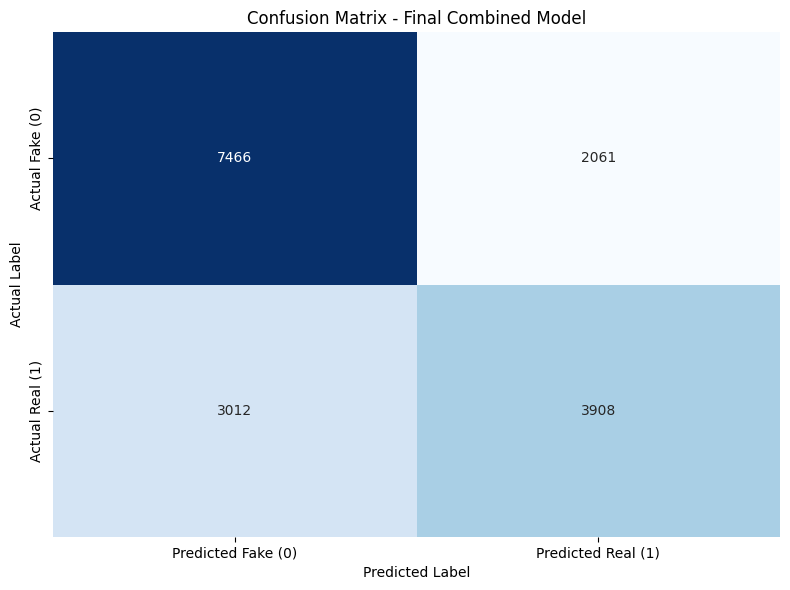


Generating Model Comparison Metrics plot...


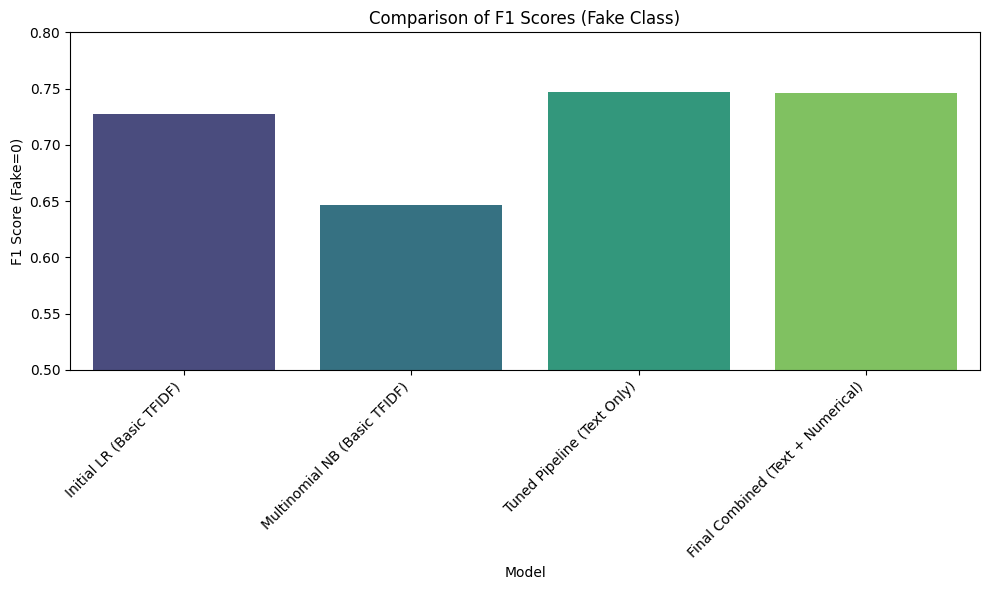

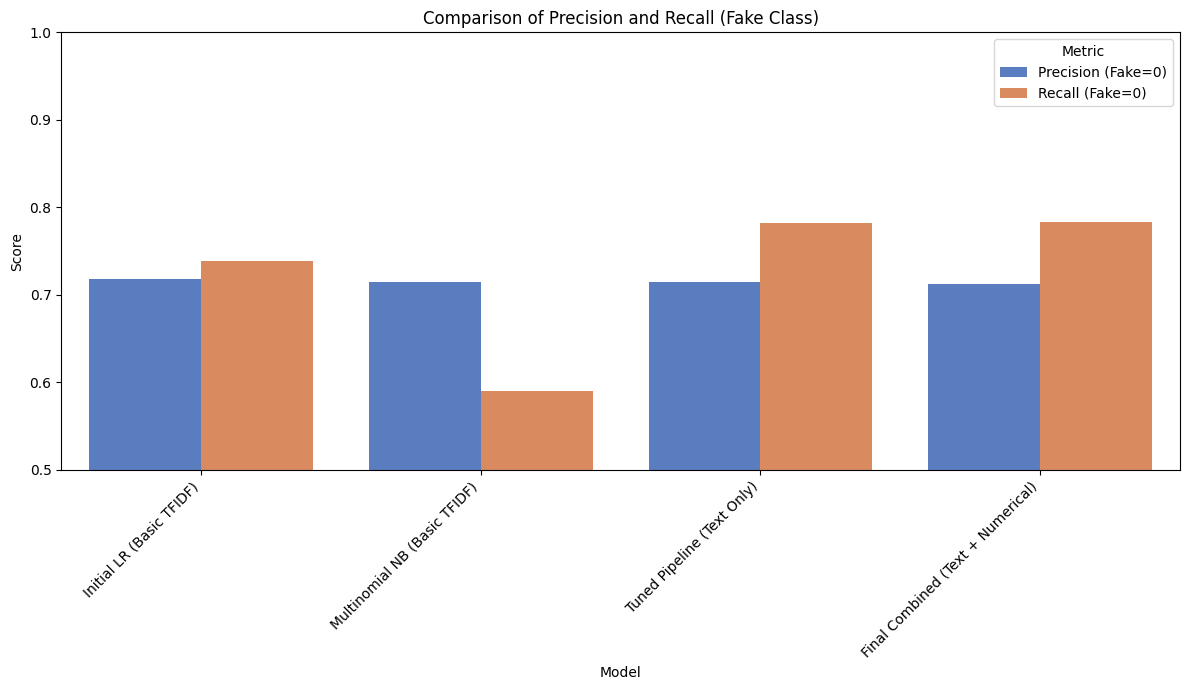


Visualization complete. Plots saved in the 'results_plots/' directory.


In [94]:
# --- Configuration ---
# Define a directory to save your plots
plot_dir = 'results_plots/'
os.makedirs(plot_dir, exist_ok=True) # Create the directory if it doesn't exist

# --- Assuming final evaluation metrics and confusion matrix are available ---
# Use the variables from your LAST evaluation run (the combined features + liblinear model)
# accuracy_final_combined, precision_final_combined, recall_final_combined, f1_final_combined, conf_matrix_final_combined
# Assuming these variables are still in your notebook's memory from the previous cell output.

# --- 1. Visualize the Final Confusion Matrix ---
print("\nGenerating Confusion Matrix plot...")

plt.figure(figsize=(8, 6))
# Use seaborn.heatmap to plot the confusion matrix
# Annotate with the counts, use a standard color map
# fmt='d' ensures integers are displayed
sns.heatmap(conf_matrix_final_combined, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Fake (0)', 'Predicted Real (1)'],
            yticklabels=['Actual Fake (0)', 'Actual Real (1)'])
plt.title('Confusion Matrix - Final Combined Model')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.savefig(os.path.join(plot_dir, 'final_confusion_matrix.png')) # Save the plot
plt.show() # Display the plot


# --- 2. Compare Key Metrics Across Models (Visual) ---
print("\nGenerating Model Comparison Metrics plot...")

# You need to manually gather the results from your previous evaluations
# Fill in the metrics for each model you want to compare
# Replace these example values with your actual results!
results_data = {
    'Model': ['Initial LR (Basic TFIDF)', 'Multinomial NB (Basic TFIDF)', 'Tuned Pipeline (Text Only)', 'Final Combined (Text + Numerical)'],
    'F1 Score (Fake=0)': [f1_log_reg, f1_nb, f1_final, f1_final_combined],
    'Precision (Fake=0)': [precision_log_reg, precision_nb, precision_final, precision_final_combined],
    'Recall (Fake=0)': [recall_log_reg, recall_nb, recall_final, recall_final_combined], 
    'Accuracy': [accuracy_log_reg, accuracy_nb, accuracy_final, accuracy_final_combined]
}

df_results = pd.DataFrame(results_data)

# Plotting F1 Score
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='F1 Score (Fake=0)', data=df_results, hue='Model', palette='viridis', legend=False)
plt.title('Comparison of F1 Scores (Fake Class)')
plt.ylabel('F1 Score (Fake=0)')
plt.ylim(0.5, 0.8) # Set y-axis limits for better comparison
plt.xticks(rotation=45, ha='right') # Rotate labels if they overlap
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, 'model_f1_comparison.png')) # Save the plot
plt.show()

# Plotting Precision and Recall side-by-side
# Melt the DataFrame for plotting
df_results_melted = df_results.melt(id_vars='Model', value_vars=['Precision (Fake=0)', 'Recall (Fake=0)'], var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 7))
sns.barplot(x='Model', y='Score', hue='Metric', data=df_results_melted, palette='muted')
plt.title('Comparison of Precision and Recall (Fake Class)')
plt.ylabel('Score')
plt.ylim(0.5, 1.0) # Set y-axis limits
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metric')
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, 'model_precision_recall_comparison.png')) # Save the plot
plt.show()


print("\nVisualization complete. Plots saved in the '{}' directory.".format(plot_dir))